1. Libraries
2. Import Model
3. Import Processor
4. Prompt, import image
5. Inference

## ***Install Required Libraries***

In [25]:
!pip install numpy==1.24.4 Pillow==10.3.0 Requests==2.31.0 torch==2.3.0 torchvision==0.18.0 transformers==4.40.2

In [26]:
!pip install accelerate

In [27]:
!mkdir my_models
!mkdir my_models/phi_3_vision

mkdir: cannot create directory ‘my_models’: File exists
mkdir: cannot create directory ‘my_models/phi_3_vision’: File exists


## ***Import Phi-3-vision model***

In [28]:
from transformers import AutoModelForCausalLM

model_id = "microsoft/Phi-3-vision-128k-instruct"

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             cache_dir="/content/my_models/phi_3_vision",
                                             device_map="cuda",
                                             trust_remote_code=True,
                                             torch_dtype="auto",
                                             _attn_implementation="eager")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 54.00 MiB. GPU 

In [ ]:
# model.config

## ***Get the Processor***

In [6]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

processing_phi3_v.py:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

image_processing_phi3_v.py:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-vision-128k-instruct:
- image_processing_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-vision-128k-instruct:
- processing_phi3_v.py
- image_processing_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
print(processor.__doc__)


    Constructs a Phi3-V processor which wraps a Phi3-V image processor and a LLaMa tokenizer into a single processor.

    [`Phi3VProcessor`] offers all the functionalities of [`Phi3VImageProcessor`] and [`LlamaTokenizerFast`]. See the
    [`~Phi3VProcessor.__call__`] and [`~Phi3VProcessor.decode`] for more information.

    Args:
        image_processor ([`Phi3VImageProcessor`], *optional*):
            The image processor is a required input.
        tokenizer ([`LlamaTokenizerFast`], *optional*):
            The tokenizer is a required input.
    


In [16]:
user_question_1 = input("Enter the first question: ")
user_question_2 = input("Enter the second question: ")
user_question_3 = input("Enter the third question: ")

Enter the first question: Are these images similar?
Enter the second question: What is the color of shirt the pedestrian is wearing beside navy blue?
Enter the third question: What is the name of the tower featured in the photo?


## ***Create Prompt***

In [17]:
# Prepare the messages with user input
messages = [
    {
        "role": "user",
        "content": f"<|image_1|>\n1.) {user_question_1} 2.) {user_question_2} 3.) {user_question_3}"
    }
]

# Create a prompt from the user-provided questions
prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
print(f"\nGenerated Prompt: {prompt}")


Generated Prompt: <|user|>
<|image_1|>
1.) Are these images similar? 2.) What is the color of shirt the pedestrian is wearing beside navy blue? 3.) What is the name of the tower featured in the photo?<|end|>
<|assistant|>



In [18]:
prompt

'<|user|>\n<|image_1|>\n1.) Are these images similar? 2.) What is the color of shirt the pedestrian is wearing beside navy blue? 3.) What is the name of the tower featured in the photo?<|end|>\n<|assistant|>\n'

## ***Fetch Input Image***

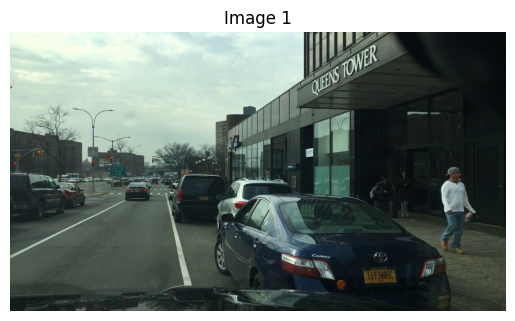

In [29]:

# Load and display the first image
url_image_1 = "https://drive.google.com/uc?export=view&id=1T-qnWzsdokXMQe0KJmdJgfUmrNTWsj7-"  # Replace with your first image link
image_1 = Image.open(requests.get(url_image_1, stream=True).raw)
image_1.show()

# Display the first image using matplotlib
plt.imshow(image_1)
plt.axis('off')  # Hide axes
plt.title("Image 1")
plt.show()


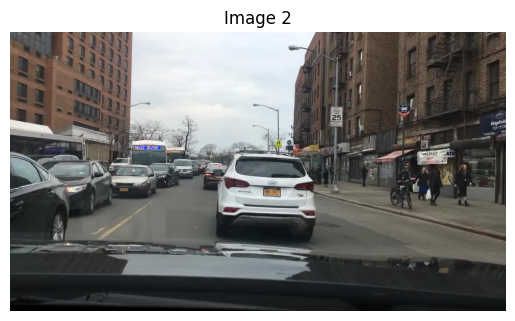

In [31]:
import requests
from PIL import Image
import matplotlib.pyplot as plt

# Load and display the second image
url_image_2 = "https://drive.google.com/uc?export=view&id=1AWQ4JN7r8jXW0bwfmprgEnuHU6KBCczg"
image_2 = Image.open(requests.get(url_image_2, stream=True).raw)
image_2.show()

# Display the second image using matplotlib
plt.imshow(image_2)
plt.axis('off')  # Hide axes
plt.title("Image 2")
plt.show()


## ***Convert Inputs to Tokens***

In [32]:
# Prepare inputs for the model with the prompt for both images
inputs_image_1 = processor(prompt, [image_1], return_tensors="pt").to("cuda:0")
inputs_image_2 = processor(prompt, [image_2], return_tensors="pt").to("cuda:0")

OutOfMemoryError: CUDA out of memory. Tried to allocate 22.00 MiB. GPU 

In [33]:
# Generation arguments for the model
generation_args = {
    "max_new_tokens": 500,
    "temperature": 0.0,
    "do_sample": False,
}

{'input_ids': tensor([[    1, 32010, 29871,  ..., 29871,    13, 32001]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'), 'pixel_values': tensor([[[[[ 1.9303,  1.9303,  1.9303,  ...,  1.9303,  1.9303,  1.9303],
           [ 1.9303,  1.9303,  1.9303,  ...,  1.9303,  1.9303,  1.9303],
           [ 1.9303,  1.9303,  1.9303,  ...,  1.9303,  1.9303,  1.9303],
           ...,
           [ 1.9303,  1.9303,  1.9303,  ...,  1.9303,  1.9303,  1.9303],
           [ 1.9303,  1.9303,  1.9303,  ...,  1.9303,  1.9303,  1.9303],
           [ 1.9303,  1.9303,  1.9303,  ...,  1.9303,  1.9303,  1.9303]],

          [[ 2.0749,  2.0749,  2.0749,  ...,  2.0749,  2.0749,  2.0749],
           [ 2.0749,  2.0749,  2.0749,  ...,  2.0749,  2.0749,  2.0749],
           [ 2.0749,  2.0749,  2.0749,  ...,  2.0749,  2.0749,  2.0749],
           ...,
           [ 2.0749,  2.0749,  2.0749,  ...,  2.0749,  2.0749,  2.0749],
           [ 2.0749,  2.0749,  2.0749,  ...,  2.0749,  2.0

## ***Inference***

In [34]:
# Generate responses using the model for both images
%%time
generate_ids_image_1 = model.generate(**inputs_image_1, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)
generate_ids_image_2 = model.generate(**inputs_image_2, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)


NameError: name 'inputs_image_1' is not defined

In [35]:
# Remove input tokens from the outputs
generate_ids_image_1 = generate_ids_image_1[:, inputs_image_1['input_ids'].shape[1]:]
generate_ids_image_2 = generate_ids_image_2[:, inputs_image_2['input_ids'].shape[1]:]


NameError: name 'generate_ids_image_1' is not defined

In [36]:
# Decode the model's responses
response_image_1 = processor.batch_decode(generate_ids_image_1, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
response_image_2 = processor.batch_decode(generate_ids_image_2, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

NameError: name 'generate_ids_image_1' is not defined

In [37]:
# Print the responses
print("\nModel Response for Image 1:")
print(response_image_1)

print("\nModel Response for Image 2:")
print(response_image_2)


Model Response for Image 1:


NameError: name 'response_image_1' is not defined

In [38]:
# Compare the responses and determine similarity or dissimilarity
if response_image_1 == response_image_2:
    print("\nThe images are considered similar based on the given questions.")
else:
    print("\nThe images are considered dissimilar based on the given questions.")

NameError: name 'response_image_1' is not defined